# 2019 Inside Airbnb Data

## Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Standardiser

In [2]:
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

## Customised Functions

### Plotting Function

In [3]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways or allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

### Caching Function

In [4]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    # os.path.getsize() gets the size of the file
    # if it doesn't exist, its size is less than 1
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Import Data

In [5]:
airbnb = pd.read_csv('2019-cleaned.csv')
print(f"Data frame is {airbnb.shape[0]:,} x {airbnb.shape[1]}")

Data frame is 85,068 x 15


In [6]:
# some shapefiles
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!


In [7]:
# boros
boros.head(n=1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."


## Data Cleaning

In [8]:
# create a column of geometry

gdf = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))

In [9]:
# set aribnb crs
gdf.set_crs(epsg=4326, inplace=True)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# reproject airbnb crs
gdf = gdf.to_crs(epsg=27700)
gdf.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [11]:
gdf.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,27595436,Central London Short stay!!!,"A very prime location! ZONE 1 London, shared f...",190730352,"Oadby, GB",1.00,1.00,51.52,-0.14,Apartment,Private room,1125,1125,Camden,$66.00,POINT (529128.755 181994.015)
1,7974622,Amazing Victoria era flat,"Cosy, refurbished Victoria era flat for those ...",42087931,London,1.00,1.00,51.53,-0.06,Condominium,Entire home/apt,1124,1124,Tower Hamlets,"$5,000.00",POINT (534474.858 183172.074)
2,18502500,Awesome penthouse flat in the heart of Dalston,A large double room available in a shared pent...,11024666,London,1.00,1.00,51.55,-0.07,Apartment,Private room,1124,1125,Hackney,$70.00,POINT (533637.476 184687.862)


In [12]:
gdf.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price', 'geometry'],
      dtype='object')>

In [13]:
gdf.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)

In [14]:
# merge airbnb and borough shapefile 
boro_listings = gpd.sjoin(gdf, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = ['latitude', 'longitude', 'index_right'])

In [15]:
# check merged data
boro_listings.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,property_type,room_type,minimum_nights,maximum_nights,borough,price,geometry,NAME,GSS_CODE
0,27595436,Central London Short stay!!!,"A very prime location! ZONE 1 London, shared f...",190730352,"Oadby, GB",1.00,1.00,Apartment,Private room,1125,1125,Camden,$66.00,POINT (529128.755 181994.015),Camden,E09000007
11,38657470,Comfy Entire Flat in Great Portland/Regent's Park,** Our flat is located in the heart of London ...,223553124,GB,9.00,9.00,Condominium,Entire home/apt,2,1125,Camden,$189.00,POINT (528898.405 182591.279),Camden,E09000007
36,25508529,Hampstead Enjoy the Exclusive Atmosphere,"In the area of South Hampstead, a fully equipp...",168364544,London,5.00,5.00,Apartment,Entire home/apt,365,1125,Camden,$133.00,POINT (525894.584 184404.247),Camden,E09000007


In [16]:
# '$', ',' are in the price column
boro_listings['price'] = boro_listings['price'].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

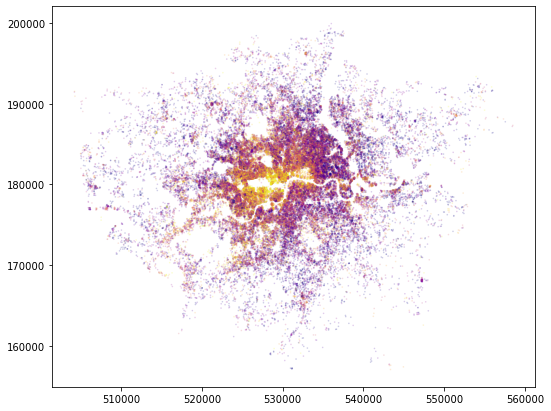

In [17]:
boro_listings.plot(column = 'price', cmap='plasma', scheme='quantiles', k=10, 
              markersize=.5, alpha=0.15, figsize=(10,7));

## Data Exploration

### Aggregate listings by boroughs

#### 1) Price per borough

In [18]:
boro_price_median = boro_listings.groupby('GSS_CODE')['price'].agg('median')
boro_price_median.sort_values(ascending = False).head(n=5)

GSS_CODE
E09000001   150.00
E09000020   150.00
E09000033   140.00
E09000007   100.00
E09000013    95.00
Name: price, dtype: float64

<AxesSubplot:>

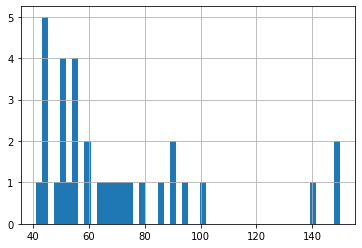

In [19]:
# median price distribution of London boroughs
# The price for one night in Wealthy boroughs are above 140 us dollars 

boro_price_median.hist(bins = 50)

#### 2) Price by Room type

In [20]:
# median room price per borough
boro_room_price = boro_listings.groupby(['GSS_CODE', 'room_type'
                              ])['price'].agg('median').reset_index().dropna(axis = 0)

boro_room_price.head(n=3)

,GSS_CODE,room_type,price
0,E09000001,Entire home/apt,151.00
1,E09000001,Hotel room,154.00
2,E09000001,Private room,65.00


#### 3) Listings with high price

In [21]:
# The median room price ranges between 40 - 160 dollars per night
# So this can be our criteria for filtering unusually expensive listings

boro_listings[(boro_listings.GSS_CODE.isin(boro_price_median[boro_price_median > 140].index)) & 
    (boro_listings.room_type != 'Entire home/apt') 
].sort_values(by='price', ascending=False).head(3)[
    ['price','room_type','property_type','name','description']
]

,price,room_type,property_type,name,description
47550,"4,500.00",Private room,Apartment,"CHELSEA!! Beautiful garden room, four poster bed!",The lovely light and airy four poster bedroom ...
30426,"3,000.00",Private room,Apartment,"London single private room, female","1 minute to bus station. 2 min to M&S. tesco ,..."
83389,"1,000.00",Hotel room,Serviced apartment,Stunning 4BD Duplex Apartment in Earls Court F11,This stunning four bedroom apartment in Kensin...


#### 4) Filter Unlikely too expensive listings
- listings' price over 300 per night

In [22]:
# filtering room types that costs more than 300 dollars per night 
# we are filtering so-called outliers as minmaxscaler is vulnerable to outliers.

to_drop = boro_listings[(boro_listings.price > 300) & (boro_listings.room_type != 'Entire home/apt') ]
print(f"Have found {to_drop.shape[0]:,} rows to drop on the basis of unlikely per night prices.")

Have found 404 rows to drop on the basis of unlikely per night prices.


In [23]:
to_drop.sort_values(by='price', ascending=False)[['price','room_type','name','description']]

,price,room_type,name,description
35208,"9,999.00",Hotel room,Eccleston Square Hotel City Queen,"Europe’s most cutting-edge luxury hideaway, Ec..."
76730,"9,999.00",Hotel room,Eccleston Square Hotel City King Room,"Europe’s most cutting-edge luxury hideaway, Ec..."
76726,"9,999.00",Hotel room,Eccleston Square Hotel Signature King Room,"Europe’s most cutting-edge luxury hideaway, Ec..."
79107,"7,852.00",Private room,Chambre Double maison vegetarienne,Boudhiste / vegetarian house filled with green...
66473,"7,693.00",Private room,Spacious Private Ground Floor Room,"On a quiet tree lined road, this ground floor ..."
...,...,...,...,...
6728,310.00,Hotel room,Moorgate One Bedroom Apartment,Design led living quarters offered by The Moor...
68022,310.00,Private room,Gorgeous bedroom in Clerkenwell,One bedroom and private bathroom in Clerkenwel...
66187,305.00,Private room,Studio close to Central London !!,Very nice and clean double private room just 2...
72865,304.00,Private room,Comfortable two bedroom,Location and surroundings 16 km London City Ai...


<AxesSubplot:>

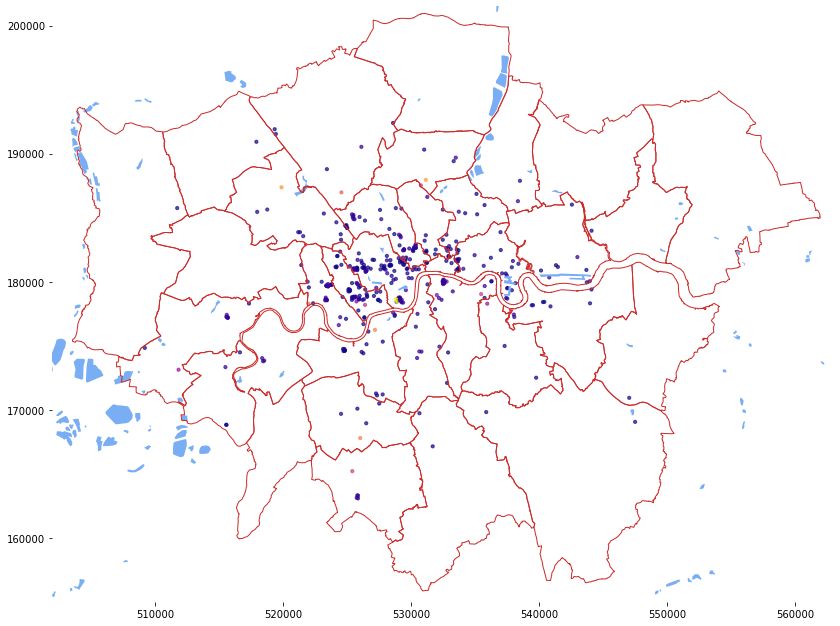

In [24]:
# plot too expensive listings
f,ax = plt_ldn(water, boros)
to_drop.plot(column='price', markersize=10, alpha=0.7, cmap='plasma', ax=ax)

#### 5) Pivot Data - Check discrete room type

In [25]:
# host_id is an unique identifier
# we can check the number of listings that each host possesses
boro_listings.groupby('host_id').host_listings_count.agg(Count = 
                                               'count').reset_index().sort_values(by = 'Count', 
                                                                                  ascending = False)

,host_id,Count
23657,33889201,999
41220,137094377,236
21496,28820321,233
43116,156158778,220
28749,48165024,213
...,...,...
27092,43023101,0
4221,2919276,0
11112,10039712,0
53029,300966707,0


In [26]:
pivot = boro_listings.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])
pivot.head(3)

Count                                    
room_type Entire home/apt Hotel room Private room Shared room
GSS_CODE                                                     
E09000001          388.00      24.00        50.00        2.00
E09000002          112.00       5.00       251.00        4.00
E09000003          699.00      29.00       916.00       14.00

In [27]:
# There are 33 boroughs in London
# and hotel room has
# 3 rows with null values
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   (Count, Entire home/apt)  33 non-null     float64
 1   (Count, Hotel room)       30 non-null     float64
 2   (Count, Private room)     33 non-null     float64
 3   (Count, Shared room)      33 non-null     float64
dtypes: float64(4)
memory usage: 1.3+ KB


In [28]:
# dropna() to convert the datatype to integer
pivot.dropna(inplace = True)

In [29]:
# convert data type
pivot_rev = pivot.astype('int')
pivot_rev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   (Count, Entire home/apt)  30 non-null     int64
 1   (Count, Hotel room)       30 non-null     int64
 2   (Count, Private room)     30 non-null     int64
 3   (Count, Shared room)      30 non-null     int64
dtypes: int64(4)
memory usage: 1.2+ KB


In [30]:
# We can check the airbnb listings by room_type
# hotel room and shared room are not that significant
# perhaps we can just do pca instead of dropping them?
pivot_rev.sum()

       room_type      
Count  Entire home/apt    47021
       Hotel room          1113
       Private room       35184
       Shared room          623
dtype: int64

In [31]:
# drop insignificant room_type
# if you think we should include them, 
# we can put them and reduce them with PCA
pivot_rev.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot_rev.drop(columns = ['Hotel room', 'Shared room'], inplace = True)

In [32]:
# normalise count of listings
pivot_norm = pd.DataFrame(index=pivot_rev.index)
for c in pivot_rev.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm[c] = pts.fit_transform(pivot_rev[c].to_numpy().reshape(-1,1))

pivot_norm.head()

,Entire home/apt,Private room
GSS_CODE,,
E09000001,-0.66,-2.33
E09000002,-1.70,-1.31
E09000003,-0.17,-0.04
E09000004,-1.89,-1.58
E09000005,0.26,0.43


In [33]:
boros.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

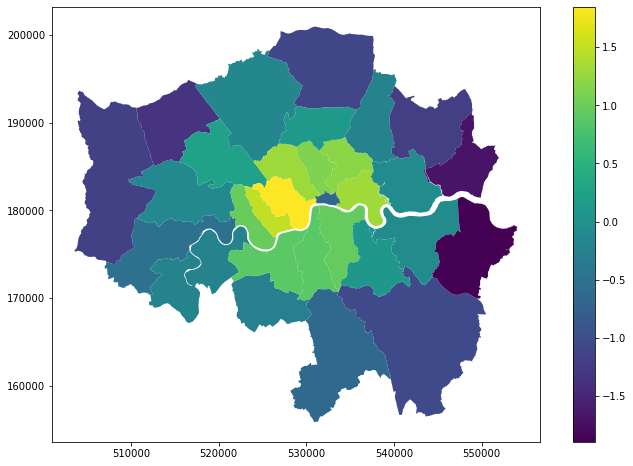

In [34]:
# left join - normalised airbnb data (entire home and private room)+ london borough shp
pnm = pd.merge(boros.set_index('GSS_CODE'), pivot_norm, left_index = True, right_index = True)
pnm.plot(column='Entire home/apt', cmap='viridis', edgecolor='none', legend=True, figsize=(12,8));

In [35]:
# We only have two columns in our pivot_norm
# And 93% of these can be explained by pca component 1
# but is it worth reducing 2 dimensions to 1D?
pcomp = PCA(n_components= 2, random_state=42)
rd    = pcomp.fit_transform(pivot_norm)
print(f"The explained variance of each component is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_

The explained variance of each component is: 93.23%, 6.77%


In [36]:
rd

array([[-2.11840241,  1.1783802 ],
       [-2.12839932, -0.26909897],
       [-0.14718247, -0.09104273],
       [-2.45816011, -0.21785598],
       [ 0.48741694, -0.11648616],
       [-1.40604992, -0.0917698 ],
       [ 1.61619775,  0.21680324],
       [-0.72636006, -0.15983855],
       [-0.06598164, -0.12683112],
       [-1.41531571, -0.16293781],
       [-0.14183246,  0.01019403],
       [ 1.94683398, -0.25703655],
       [ 1.0925874 ,  0.29709696],
       [ 0.28517401, -0.11265611],
       [-1.74956039, -0.12183684],
       [-1.40594876, -0.2474081 ],
       [-0.79699747,  0.06952535],
       [ 1.4413506 ,  0.15017696],
       [ 1.06865171,  1.02721477],
       [ 1.5289418 , -0.26933023],
       [ 0.35778882, -0.20874813],
       [-0.4108335 ,  0.01550674],
       [ 0.10502581, -0.24929025],
       [-1.36066595, -0.33208752],
       [-0.60853526,  0.3033817 ],
       [ 1.49648762, -0.12887005],
       [ 2.51488123, -0.65130843],
       [-0.34757449,  0.02968003],
       [ 1.2463332 ,

In [37]:
# we are only choosing first component
# I just kept these 1 col

airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
                {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0]},
                index=pivot.index)



# In case, you want to keep two cols
#airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
 #               {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0], 
  #              '2019_Airbnb Component 2': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]},
   #             index=pivot.index)

airbnb_pca.head()

,2019_Airbnb Component 1
GSS_CODE,
E09000001,-0.86
E09000002,-0.87
E09000003,-0.07
E09000004,-1.00
E09000005,0.18


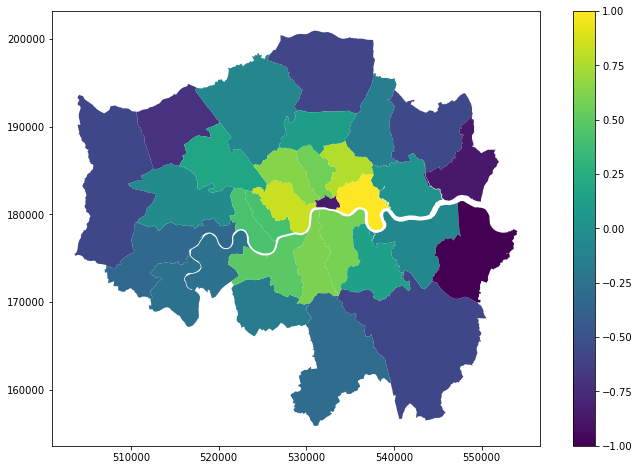

In [38]:
# seems like there is a problem with shape file
pcanm = pd.merge(boros.set_index('GSS_CODE'), airbnb_pca, left_index=True, right_index=True)
pcanm.plot(column='2019_Airbnb Component 1', cmap='viridis', edgecolor='none', legend=True, figsize=(12,8));

## Data Merge

In [43]:
# Result Set from merge
# set 'gss_code' as an index to merge data
ldn_gss_idx = boro_listings.set_index('GSS_CODE')

rs = pd.merge(ldn_gss_idx, airbnb_pca, left_index=True, right_index = True)
len(rs)

83941

#### Write to the previous DataFrame

Originally, the dataframe 'cluster' should be data with standardised census tract

As we don't have the data yet, I subsetted the merged airbnb data (pca + airbnb data)

The data that will be used for clustering should be in numeric types

In [40]:
# Add median, mean price data and the PCA-reduced Airbnb data
# we have to create a data frame just for clustering
cluster = rs.reset_index().iloc[:, [0, -1]].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1 = rs.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
cluster['2019_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1.values.reshape(-1,1))), index=s1.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2 = rs.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
cluster['2019_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

cluster

# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2019_Airbnb Component 1,2019_median_price,2019_mean_price
GSS_CODE,,,
E09000001,-0.86,1.00,0.66
E09000001,-0.86,1.00,0.66
E09000001,-0.86,1.00,0.66
E09000001,-0.86,1.00,0.66
E09000001,-0.86,1.00,0.66
...,...,...,...
E09000033,0.83,0.82,0.99
E09000033,0.83,0.82,0.99
E09000033,0.83,0.82,0.99


## 1) K-Means Clustering

The code below can be used when we have a specific clustering number in mind.

In [52]:
# fit numeric values - airbnb PCA, mean and median price
# we are fitting the data we created above for clustering 

c_nm   = 'KMeans' # Clustering name
k_pref = 5 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cluster) # The process

In [53]:
cluster

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,KMeans
GSS_CODE,,,,
E09000001,-0.86,1.00,0.66,1
E09000001,-0.86,1.00,0.66,1
E09000001,-0.86,1.00,0.66,1
E09000001,-0.86,1.00,0.66,1
E09000001,-0.86,1.00,0.66,1
...,...,...,...,...
E09000033,0.83,0.82,0.99,1
E09000033,0.83,0.82,0.99,1
E09000033,0.83,0.82,0.99,1


In [54]:
# Assign clustering number to each listing
# Warning!
# We are creating Kmeans column on the original datasets
# The dataset we created for clustering is only used for index nothing more.
rs[c_nm] = pd.Series(kmeans.labels_, index= cluster.index)

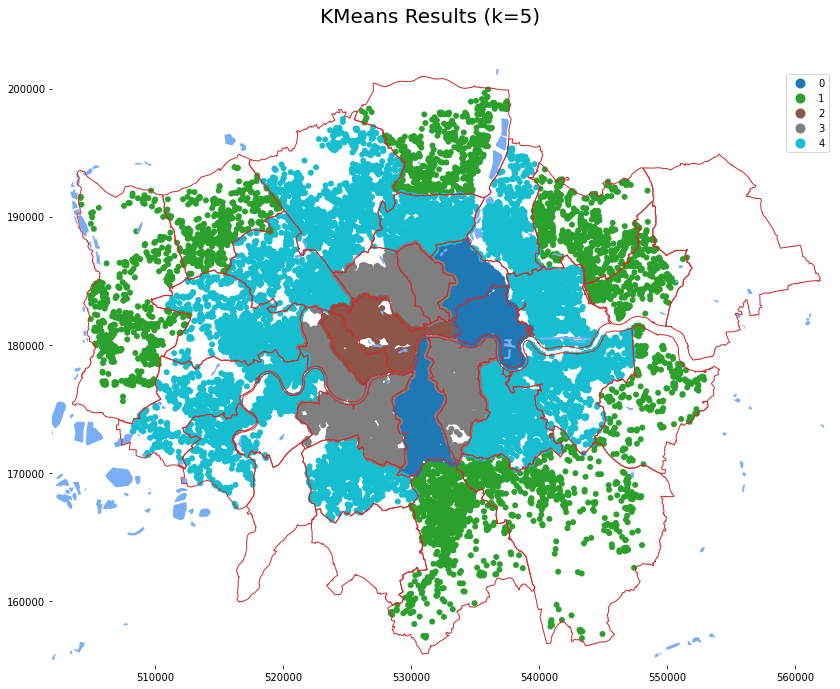

In [56]:
# plot
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

## 2) K-Means Clustering

Finding an optimal K-Means number through for loop.

But the K-Means number seems a little bit too big.

### Optimal K-Means Number Search Loop

In [62]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# This took a lot of time for me
# and K-Means number 19 seems a little too big.
import time
%time

x = []
y = []

# For resolutions of 'k' in the range 2..40
for k in range(2,20):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(cluster)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cluster, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.68 µs
..................

#### Plot Silhoutte Score


Largest silhouette score was 0.8743 for k=19


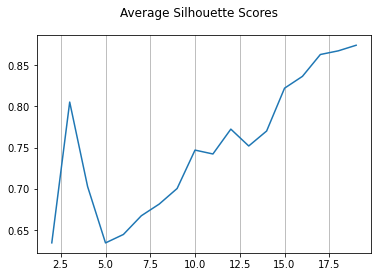

In [63]:
print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gca().xaxis.grid(True);
plt.gcf().suptitle("Average Silhouette Scores");

#### Create K-Means column on original data

In [64]:
k_pref=19

#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cluster)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cluster.index, name=c_nm)

# We do this for plotting
rs[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(cluster, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(cluster, kmeans.labels_)

#### Plot Diagnostics

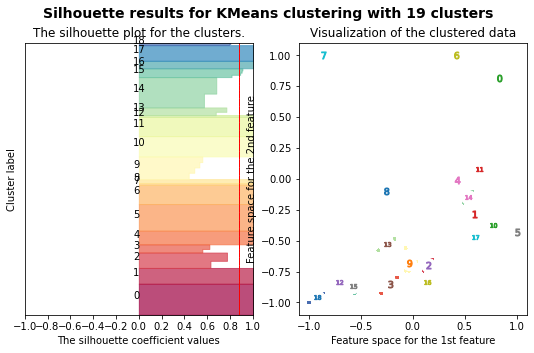

In [66]:
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, cluster.shape[0] + (k_pref + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k_pref)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k_pref)
    ax2.scatter(cluster[cluster.columns[0]], cluster[cluster.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

#### K-Means Map

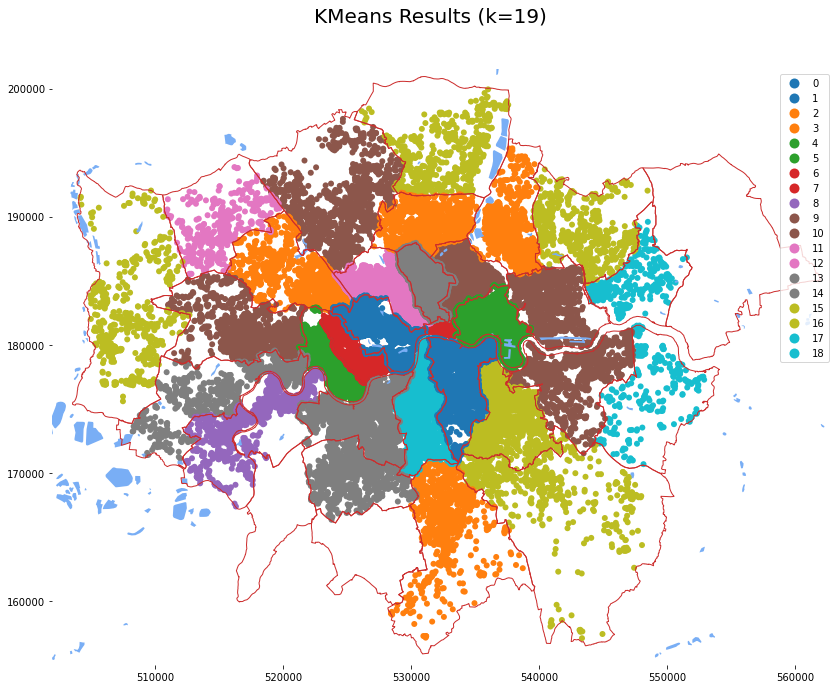

In [67]:
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);